# Extract the training and test sets and creation of a binary classification problem

- Orginal Dataset: [SemCity Toulouse ](http://rs.ipb.uni-bonn.de/data/semcity-toulouse/)


## Import packages

In [1]:
import tifffile as tiff
import numpy as np
from spectral import *
from utils import *
import matplotlib.pyplot as plt
from sklearn import preprocessing
from matplotlib import colors

# set the random seed
seed=0
np.random.seed(seed)

## Load the dataset (multispectral images)

We use only two sub-regions of the entire SemCity Toulouse dataset: 

- For training: SemCity-Toulouse\img_multispec_05\TLS_BDSD_M\TLS_BDSD_M_04.tif
- For testing:  SemCity-Toulouse\img_multispec_05\TLS_BDSD_M\TLS_BDSD_M_08.tif

Each region has size [3504 x 3452 x 8] and has spatial resolution of 50 cm 

Tile 4 with shape (3452, 3504, 8)
Tile 8 with shape (3452, 3504, 8)


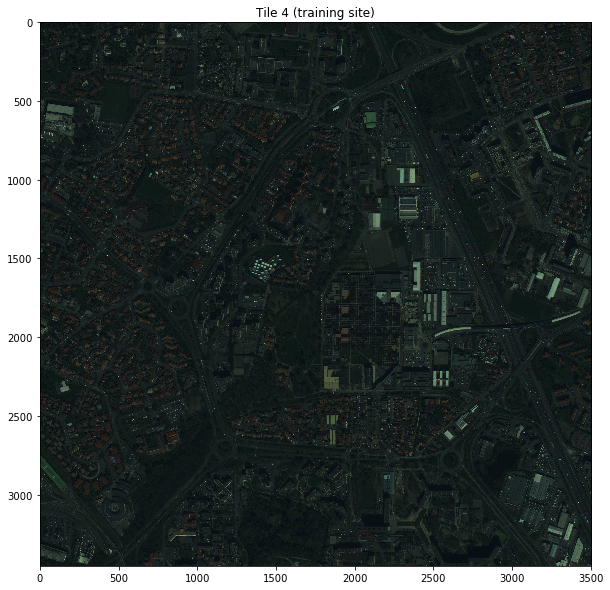

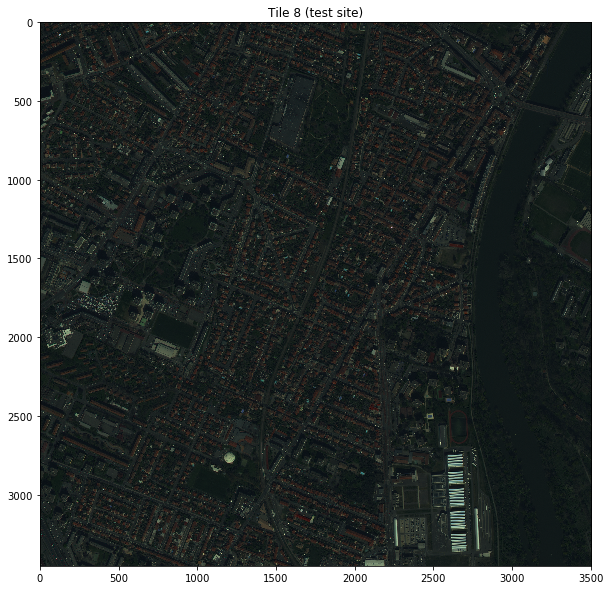

In [2]:
# Read tiff files
tile_4 = tiff.imread('TLS_BDSD_M_04.tif')
tile_8 = tiff.imread('TLS_BDSD_M_08.tif')

# Info and Visualization
print('Tile 4 with shape',tile_4.shape)  
print('Tile 8 with shape',tile_8.shape) 

view = imshow(tile_4, (3, 2, 1), title='Tile 4 (training site)',figsize=(10, 10))
view = imshow(tile_8, (3, 2, 1), title='Tile 8 (test site)',figsize=(10, 10))


## Load the dataset (groundtruth)

The corresponding gorundtruth are:

- SemCity-Toulouse\instances_building_05\TLS_instances_building\TLS_instances_building_04.tif
- SemCity-Toulouse\instances_building_05\TLS_instances_building\TLS_instances_building_08.tif







Groundtruth of Tile 4 with shape (3452, 3504, 3)
Groundtruth of Tile 8 with shape (3452, 3504, 3)


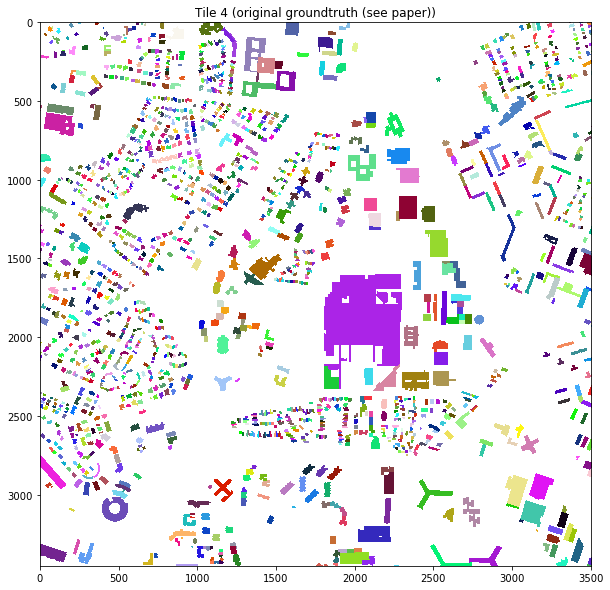

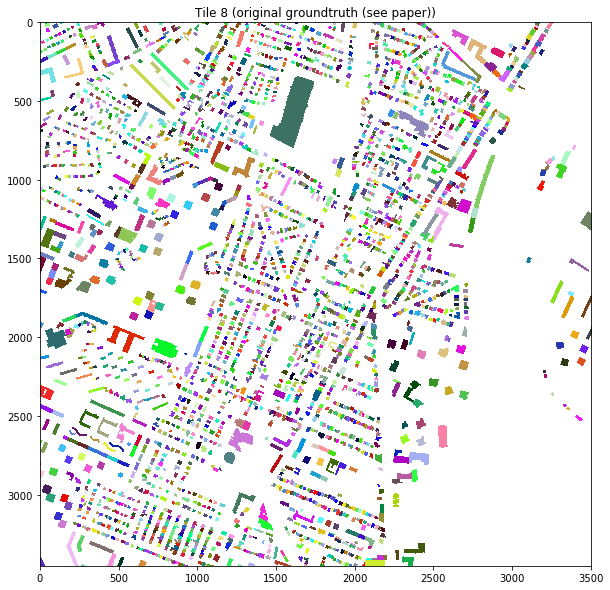

In [3]:
# Read tiff files
tile_4_gt_rgb = tiff.imread('TLS_instances_building_04.tif')
tile_8_gt_rgb = tiff.imread('TLS_instances_building_08.tif')

# Info and Visualization
print('Groundtruth of Tile 4 with shape',tile_4_gt_rgb.shape)  
print('Groundtruth of Tile 8 with shape',tile_8_gt_rgb.shape) 

view= imshow(classes=tile_4_gt_rgb, title='Tile 4 (original groundtruth (see paper))',figsize=(10, 10))
view= imshow(classes=tile_8_gt_rgb, title='Tile 8 (original groundtruth (see paper))',figsize=(10, 10))

## Make a binary classification problem 

The two classes are:

- Class 0: no building
- Class 1: building

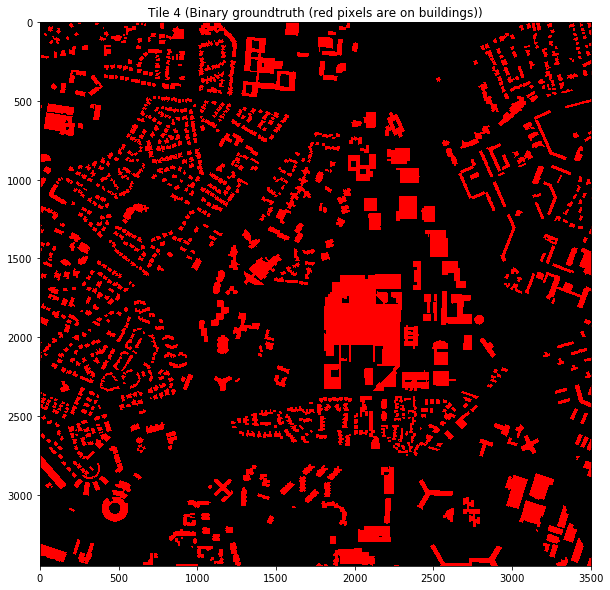

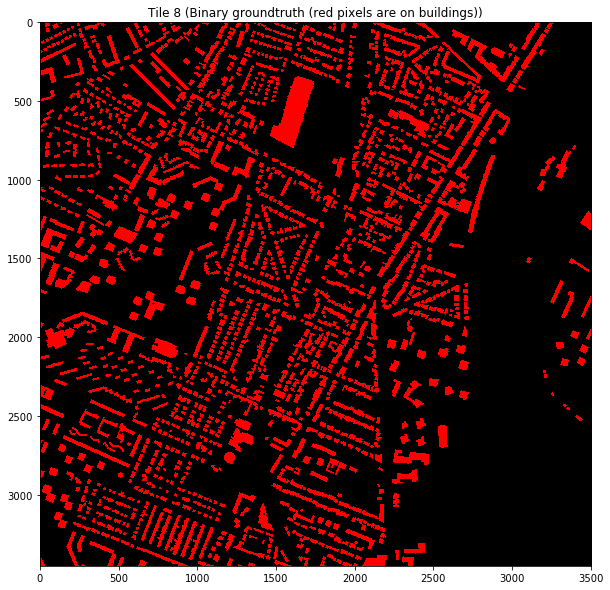

In [4]:
tile_4_binary_gt=tile_4_gt_rgb[:,:,0]
tile_4_binary_gt=np.where(tile_4_binary_gt<255,1,tile_4_binary_gt)   # pixels on buildings 
tile_4_binary_gt=np.where(tile_4_binary_gt==255,0,tile_4_binary_gt)  # pixels on other classes 
view= imshow(classes=tile_4_binary_gt,title='Tile 4 (Binary groundtruth (red pixels are on buildings))',figsize=(10, 10))

tile_8_binary_gt=tile_8_gt_rgb[:,:,0]
tile_8_binary_gt=np.where(tile_8_binary_gt<255,1,tile_8_binary_gt)   # pixels on buildings 
tile_8_binary_gt=np.where(tile_8_binary_gt==255,0,tile_8_binary_gt)  # pixels on other classes 
view= imshow(classes=tile_8_binary_gt,title='Tile 8 (Binary groundtruth (red pixels are on buildings))',figsize=(10, 10))

## Build the training set

 - Extract in a random way a number of samples from each class
 - Set the number with 'samples_per_class' (i.e., crucial parameter for the QA SVM)

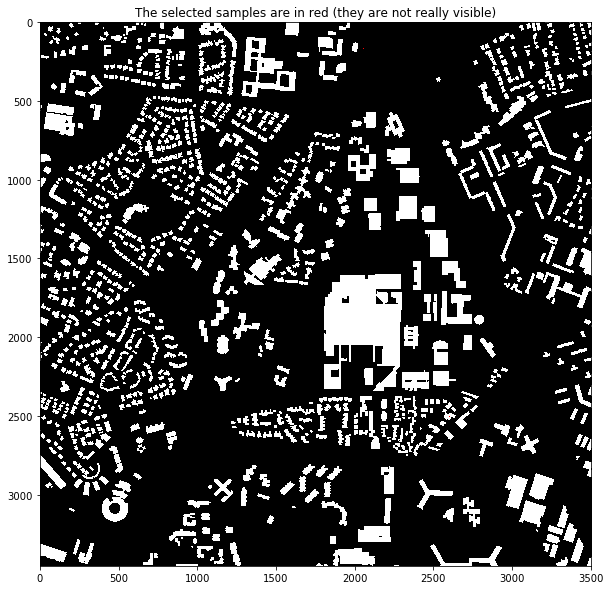

In [5]:
# Reshape the multispetral image (from [rows,col,bands] to [samples,features])
tile_4_reshaped=np.reshape(tile_4,(tile_4.shape[0]*tile_4.shape[1],tile_4.shape[2]))
# Reshape the groundtruth (from [rows,col] to [labels])
training_set=np.reshape(tile_4_binary_gt,(tile_4_binary_gt.shape[0]*tile_4_binary_gt.shape[1]))

#######CREATE A TRAINING SET THAT IS BALANCED AND WITH A SUBSET OF SAMPLES

# Number of samples to exctract randomy from each class
samples_per_class=50
# You could use instead the pecentage, but it is not recommaned (there are much more samples from class 0, i.e., no building)
####train_fraction=0.01  


###### Random extraction 
distinct_labels = np.unique(training_set)
selection = np.full(training_set.shape, 0, dtype=np.int8)  # Will be a binary mask, where 1 means that the pixel is selected

# sample the labels by shuffling and index cut-off using label distribution
for label in distinct_labels:
    indices = np.where(training_set == label)[0]
    # shuffle the indices and select the train_fraction elements for training
    np.random.shuffle(indices)
    #train_indices = indices[:int(np.round(train_fraction * indices.shape[0]))]  # take a fraction 
    train_indices = indices[:samples_per_class]  # take same number from each class
    selection[train_indices] = 1

##################  THIS IS THE SELECTED TRAINING SET ################## 
X_train=preprocessing.scale(tile_4_reshaped[np.argwhere(selection==1)][:,0,:])   # Data
Y_train=training_set[np.argwhere(selection==1)].ravel()                          # Labels


## Visualize the samples selected for the training set (in red)
map_selected_samples=np.reshape(selection,(tile_4_binary_gt.shape[0],tile_4_binary_gt.shape[1]))
view = imshow(tile_4_binary_gt,classes=map_selected_samples,figsize=(10, 10),title='The selected samples are in red (they are not really visible)')
view.set_display_mode('overlay')
view.class_alpha = 1

## Build the test set
 - Select a subregion from the image tile_8 (3452, 3504, 3) for the testing
 - For example we extract the the upper left corner (500,500,3)

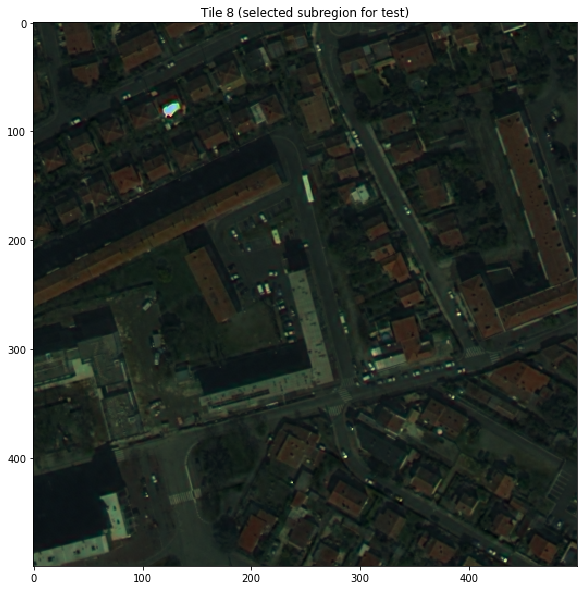

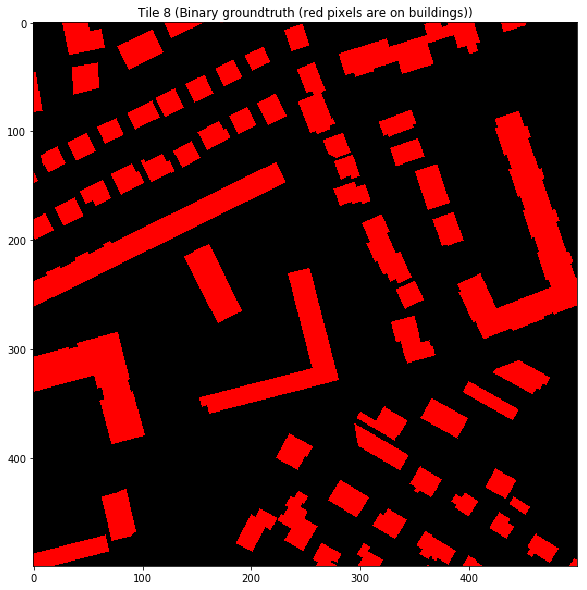

In [6]:
##### Extract a smaller region from the hyperspectral image and the groundtruth 

# Define the size
n_rows=500
n_cols=500

# Extract
tile_8_subregion=tile_8[0:n_rows,0:n_cols,:]
tile_8_binary_gt_subregion=tile_8_binary_gt[0:n_rows,0:n_cols]

##### Reshape the multispetral image (from [rows,col,bands] to [samples,features])
tile_8_reshaped=np.reshape(tile_8_subregion,(tile_8_subregion.shape[0]*tile_8_subregion.shape[1],tile_8_subregion.shape[2]))

# Reshape the groundtruth (from [rows,col] to [labels])
test_set=np.reshape(tile_8_binary_gt_subregion,(tile_8_binary_gt_subregion.shape[0]*tile_8_binary_gt_subregion.shape[1]))

##################  THIS IS THE SELECTED TEST SET ################## 
X_test=preprocessing.scale(tile_8_reshaped)      
Y_test=test_set

##### Visualize the test set
X_test_image=np.reshape(X_test,(tile_8_subregion.shape[0],tile_8_subregion.shape[1],tile_8_subregion.shape[2]))
Y_test_image=np.reshape(Y_test,(tile_8_binary_gt_subregion.shape[0],tile_8_binary_gt_subregion.shape[1]))

view = imshow(X_test_image, (3, 2, 1), title='Tile 8 (selected subregion for test)',figsize=(10, 10))
view= imshow(classes=Y_test_image,title='Tile 8 (Binary groundtruth (red pixels are on buildings))',figsize=(10, 10))


## Save the training and test sets

In [7]:
# Save training set
np.save('X_train_tile_4.npy',X_train)
np.save('Y_train_tile_4.npy',Y_train)

# Save test set
np.save('X_test_tile_8_subregion.npy',X_test)
np.save('Y_test_tile_8_subregion.npy',Y_test)

In [8]:
cmap = colors.ListedColormap(['black', 'red'])
plt.imsave('tile_8_binary_gt_subregion.png',tile_8_binary_gt_subregion,cmap=cmap)